<a href="https://colab.research.google.com/github/EvagAIML/CASE-Visa-Applicant-Screening/blob/main/Copy_of_EasyVisa_Full_Code_Notebook_(2)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Business Context

Businesses in the United States face consistent challenges in sourcing qualified talent.  
To fill skill shortages, employers often hire foreign professionals under visa programs governed by the **Immigration and Nationality Act (INA)**.  

The **Office of Foreign Labor Certification (OFLC)** reviews and certifies these employer applications when employers demonstrate valid labor shortages and offer competitive wages.  

This dataset represents real-world visa applications, each labeled as **CERTIFIED** or **DENIED**.  
By analyzing patterns in this data, we aim to predict the likelihood of visa certification and understand which factors most influence these decisions.

### Problem Definition

The goal is to build a supervised learning model that predicts whether a visa application will be **CERTIFIED** or **DENIED**.  

**Target variable:** `case_status`  
**Problem type:** Binary Classification  
**Evaluation metrics:** ROC-AUC (primary), F1, Precision, Recall, Accuracy  
**Business value:** Early identification of likely certification outcomes can help employers optimize hiring and compliance strategies.

### Data Description

In [1]:
# ===========================
# 1. LOADING AND SETUP
# ===========================

# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Configure visualization style
sns.set_theme(style="whitegrid", context="talk")

# ---------------------------
# Load dataset
# ---------------------------
# Update the file path if running locally
df = pd.read_csv("https://raw.githubusercontent.com/EvagAIML/CASE-Visa-Applicant-Screening/refs/heads/main/EasyVisa%20Data%20Science.csv")

# Look at the dataset
print("Shape of dataset:", df.shape)
display(df.head())

# Basic info and nulls
df.info()
print("\nMissing values per column:\n", df.isnull().sum())

Shape of dataset: (25480, 12)


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB

Missing values per column:
 case_id                  0
continent                0
education_of_emplo

### Summary: Loading and Setup

The dataset was successfully loaded from GitHub into a pandas DataFrame containing 25,480 records and 12 columns. It includes both categorical and numerical variables with appropriate data types and no missing values. The data appears complete and consistent, making it ready for further analysis and integrity validation.

### Data Understanding

Before transformation or modeling, the dataset’s integrity is checked.  
This includes verifying record and feature counts, column types, missing values, duplicates, unique counts, and logical consistency (e.g., no negative employee counts or invalid years).

In [2]:
# ===============================================
# Data Understanding — Integrity Checks (read-only)
# ===============================================

import pandas as pd
import numpy as np

# 0) Preconditions
assert 'df' in globals() and isinstance(df, pd.DataFrame), "DataFrame `df` is not loaded."

# 1) Shape and basic info
print("=== Dataset Shape ===")
rows, cols = df.shape
print(f"Records: {rows}, Features: {cols}\n")

print("=== Column Information ===")
df.info()
print()

# 2) Missing values
print("=== Missing Values per Column ===")
missing = df.isnull().sum()
total_missing = int(missing.sum())
if total_missing == 0:
    print("No missing values detected.\n")
else:
    print(f"Total missing values: {total_missing}")
    print(missing[missing > 0].to_string(), "\n")

# 3) Duplicate rows
print("=== Duplicate Records ===")
dup_count = int(df.duplicated().sum())
print(f"Duplicate rows: {dup_count}\n")

# 4) Data types and unique counts
print("=== Column Data Types ===")
print(df.dtypes.to_string(), "\n")

print("=== Unique Value Counts per Column ===")
print(df.nunique().to_string(), "\n")

# 5) Logical consistency checks
print("=== Logical Consistency Checks ===")

# 5a) Negative values in numeric columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
if num_cols:
    neg_counts = (df[num_cols] < 0).sum()
    neg_counts = neg_counts[neg_counts > 0]
    if not neg_counts.empty:
        print("Negative values detected:")
        print(neg_counts.to_string())
    else:
        print("No negative values detected in numeric columns.")
else:
    print("No numeric columns detected.")

# 5b) Establishment year plausibility (if present)
if 'yr_of_estab' in df.columns:
    yrs = pd.to_numeric(df['yr_of_estab'], errors='coerce')
    invalid_year_mask = (yrs < 1800) | (yrs > 2025) | yrs.isna()
    invalid_years = int(invalid_year_mask.sum())
    print(f"\nyr_of_estab outside [1800, 2025] or non-parsable: {invalid_years}")
else:
    print("\nColumn `yr_of_estab` not present; year plausibility check skipped.")

# 6) Target distribution (if present)
if 'case_status' in df.columns:
    print("\n=== Target Variable (case_status) Distribution ===")
    vc = df['case_status'].value_counts(dropna=False)
    pct = (vc / len(df) * 100).round(2)
    print(pd.DataFrame({'Count': vc, 'Percent': pct}).to_string(index=True))
else:
    print("\nTarget column `case_status` not found.")

# 7) Summary line
print("\n=== Summary ===")
print(f"- Total records: {rows}")
print(f"- Total features: {cols}")
print(f"- Missing values: {total_missing}")
print(f"- Duplicate rows: {dup_count}")
if num_cols:
    neg_total = int(((df[num_cols] < 0).sum()).sum())
    print(f"- Total negative numeric entries: {neg_total}")
if 'yr_of_estab' in df.columns:
    print(f"- Invalid or out-of-range `yr_of_estab` rows: {invalid_years}")
print("Integrity check complete.")

=== Dataset Shape ===
Records: 25480, Features: 12

=== Column Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB

=== Missing Values pe

### Summary: Data Understanding

A detailed integrity check was performed to confirm the dataset’s completeness and logical consistency before any transformation or modeling. The dataset contains 25,480 records and 12 features, with no missing values or duplicate entries. Data types were validated, consisting of nine categorical and three numerical variables.

The analysis identified 33 negative values in the no_of_employees column, which will require correction before modeling. All establishment years (yr_of_estab) fall within the valid range of 1800–2025, indicating no temporal inconsistencies. The target variable case_status shows a binary distribution of approximately 67% Certified and 33% Denied cases, suggesting a moderate class imbalance.

### Primary Data Cleaning

Only essential corrections are made before data splitting to preserve integrity. Negative employee counts are corrected, establishment years are validated, and categorical fields are standardized for consistency. Wage units are checked for uniformity, and non-informative identifiers are reviewed for removal. This ensures the dataset is accurate and consistent while minimizing the risk of data distortion.

In [3]:
# ===========================================
# Primary Data Cleaning (essential fixes only)
# - Non-destructive to `df` (creates `df_clean`)
# - Minimal, pre-split corrections
# ===========================================

import pandas as pd
import numpy as np

assert 'df' in globals() and isinstance(df, pd.DataFrame), "`df` is not loaded."

# Work on a copy (do not mutate original)
df_clean = df.copy()

rows_before = len(df_clean)
reports = []

# ---------------------------
# 1) Normalize categorical fields (minimal)
#    - Trim whitespace
#    - Standardize known Y/N fields to YES/NO
#    - Uppercase other text for consistency
# ---------------------------
yn_cols = [c for c in ['has_job_experience', 'requires_job_training', 'full_time_position'] if c in df_clean.columns]

def to_yes_no(x):
    s = str(x).strip().lower()
    yes_set = {'y','yes','true','t','1'}
    no_set  = {'n','no','false','f','0'}
    if s in yes_set: return 'YES'
    if s in no_set:  return 'NO'
    return str(x).strip().upper()  # leave as-is but normalized

# Trim and normalize objects
for c in df_clean.select_dtypes(include='object').columns:
    if c in yn_cols:
        df_clean[c] = df_clean[c].apply(to_yes_no)
    else:
        df_clean[c] = df_clean[c].astype(str).str.strip().str.upper()

reports.append(f"Text normalization applied to object columns; Y/N fields standardized: {', '.join(yn_cols) if yn_cols else 'none'}.")

# ---------------------------
# 2) Fix negative employee counts (replace with median of valid)
# ---------------------------
neg_fixed = 0
if 'no_of_employees' in df_clean.columns:
    emp = pd.to_numeric(df_clean['no_of_employees'], errors='coerce')
    neg_mask = emp < 0
    neg_fixed = int(neg_mask.sum())
    if neg_fixed > 0:
        med_emp = emp[~neg_mask].median()
        df_clean.loc[neg_mask, 'no_of_employees'] = med_emp
reports.append(f"Negative 'no_of_employees' corrected: {neg_fixed}.")

# ---------------------------
# 3) Validate establishment year (keep realistic range 1800–2025)
#    - Remove rows with out-of-range or non-parsable years
# ---------------------------
years_dropped = 0
if 'yr_of_estab' in df_clean.columns:
    yrs = pd.to_numeric(df_clean['yr_of_estab'], errors='coerce')
    bad_year = yrs.lt(1800) | yrs.gt(2025) | yrs.isna()
    years_dropped = int(bad_year.sum())
    if years_dropped > 0:
        df_clean = df_clean.loc[~bad_year].copy()
reports.append(f"Rows removed for invalid 'yr_of_estab': {years_dropped}.")

# ---------------------------
# 4) Wage unit standardization (create yearly metric)
#    - Do NOT overwrite original; add 'prevailing_wage_yearly'
# ---------------------------
unknown_units = 0
created_wage_yearly = False
if {'prevailing_wage', 'unit_of_wage'}.issubset(df_clean.columns):
    u = df_clean['unit_of_wage'].astype(str).str.upper().str.strip()
    # Common variants mapped to annualization factors
    factors = {
        'HOUR': 2080, 'HOURLY': 2080, 'HR': 2080, 'HRS': 2080,
        'WEEK': 52, 'WEEKLY': 52,
        'MONTH': 12, 'MONTHLY': 12,
        'YEAR': 1, 'YEARLY': 1, 'ANNUAL': 1, 'PER YEAR': 1
    }
    factor = u.map(factors)
    unknown_units = int(factor.isna().sum())
    factor = factor.fillna(1)  # fallback: assume already annual if unknown
    w = pd.to_numeric(df_clean['prevailing_wage'], errors='coerce')
    df_clean['prevailing_wage_yearly'] = w * factor
    created_wage_yearly = True
reports.append(f"'prevailing_wage_yearly' created: {created_wage_yearly} (unknown units encountered: {unknown_units}).")

# ---------------------------
# 5) Drop non-informative ID columns (only if strictly unique)
# ---------------------------
dropped_ids = []
for col in ['case_id', 'id', 'caseid']:
    if col in df_clean.columns:
        # Drop only if it's a pure identifier (all or near-all unique)
        if df_clean[col].nunique(dropna=False) >= 0.99 * len(df_clean):
            df_clean.drop(columns=[col], inplace=True)
            dropped_ids.append(col)
reports.append(f"ID columns dropped (uniqueness-based): {', '.join(dropped_ids) if dropped_ids else 'none'}.")

# ---------------------------
# 6) Report
# ---------------------------
rows_after = len(df_clean)

print("=== Primary Data Cleaning (Essential, Pre-Split) ===")
print(f"Rows before: {rows_before} | Rows after: {rows_after} | Net change: {rows_after - rows_before}")
for r in reports:
    print("-", r)

# Quick sanity: no mutation of original dataframe
assert len(df) == rows_before, "Original `df` row count changed — this step should not mutate `df`."

# df_clean is the cleaned dataset to use in subsequent steps (EDA → split → prep → modeling)

=== Primary Data Cleaning (Essential, Pre-Split) ===
Rows before: 25480 | Rows after: 25480 | Net change: 0
- Text normalization applied to object columns; Y/N fields standardized: has_job_experience, requires_job_training, full_time_position.
- Negative 'no_of_employees' corrected: 33.
- Rows removed for invalid 'yr_of_estab': 0.
- 'prevailing_wage_yearly' created: True (unknown units encountered: 0).
- ID columns dropped (uniqueness-based): case_id.


### Primary Data Cleaning

Before the data was divided for modeling, targeted corrections were applied to ensure logical and structural accuracy. Categorical variables were standardized for consistency, and invalid employee counts were replaced with the median of valid values. Establishment years were verified to be within plausible limits, and wage values were standardized on an annual scale to maintain comparability. Unique identifiers that added no predictive value were removed. These minimal adjustments preserved data integrity while ensuring readiness for analysis and model development.

### Exploratory Data Analysis (Univariate and Bivariate)

Exploratory analysis is performed to understand the underlying structure and relationships within the data. Univariate analysis examines each feature individually to assess distributions, variability, and potential outliers. Bivariate analysis explores relationships between independent variables and the target outcome to identify patterns, correlations, and predictive trends. This step provides a foundation for selecting relevant features and guiding model design without altering the dataset.

=== EDA Context ===
Records = 25480 | Features = 12
This analysis is diagnostic only and does not alter the dataset.

Detected numeric columns: ['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'prevailing_wage_yearly']
Detected categorical columns: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']
Target column: case_status 

=== Univariate Analysis: Numeric Features ===


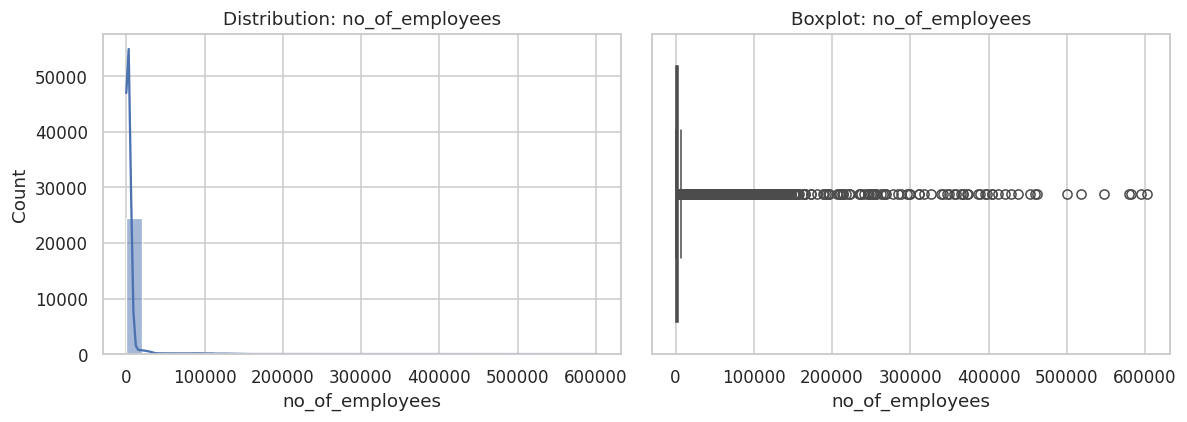

no_of_employees summary:
count     25480.000000
mean       5669.801531
std       22877.371642
min          12.000000
25%        1028.000000
50%        2112.000000
75%        3504.000000
max      602069.000000
Skewness = 12.266 | Negative values = 0



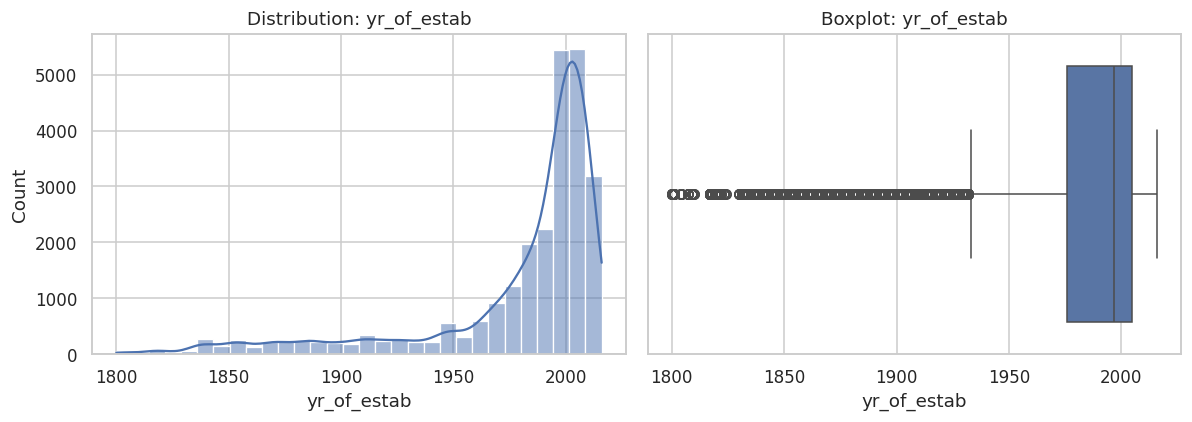

yr_of_estab summary:
count    25480.000000
mean      1979.409929
std         42.366929
min       1800.000000
25%       1976.000000
50%       1997.000000
75%       2005.000000
max       2016.000000
Skewness = -2.037 | Negative values = 0



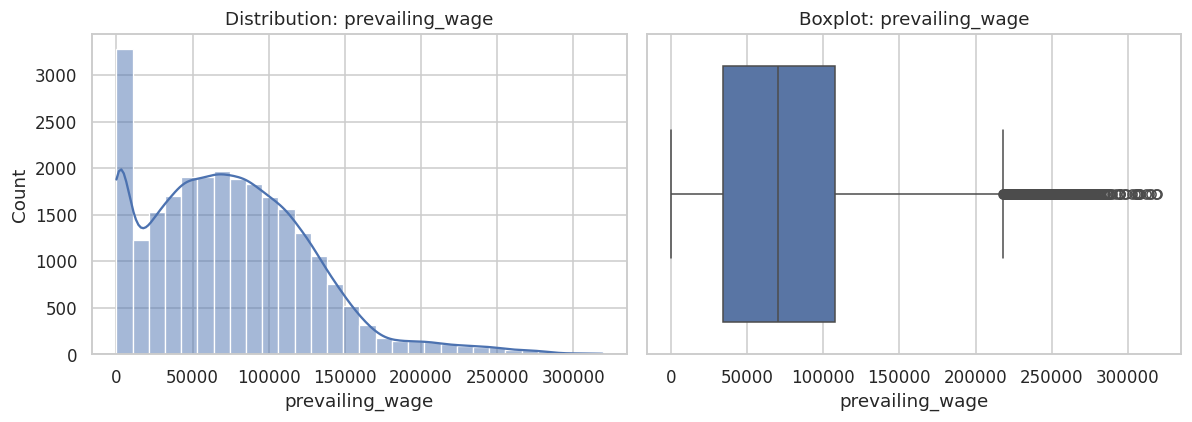

prevailing_wage summary:
count     25480.000000
mean      74455.814592
std       52815.942327
min           2.136700
25%       34015.480000
50%       70308.210000
75%      107735.512500
max      319210.270000
Skewness = 0.756 | Negative values = 0



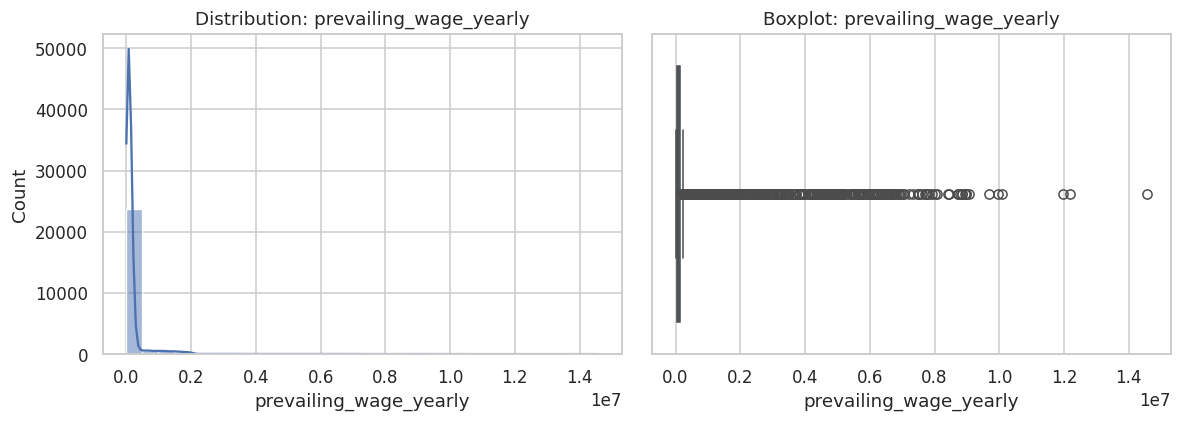

prevailing_wage_yearly summary:
count    2.548000e+04
mean     1.973912e+05
std      5.785917e+05
min      1.000000e+02
25%      4.710796e+04
50%      8.283946e+04
75%      1.248250e+05
max      1.456915e+07
Skewness = 8.977 | Negative values = 0


=== Univariate Analysis: Categorical Features ===

continent frequency (top 20 shown):


,count,percent
continent,,
ASIA,16861,66.17
EUROPE,3732,14.65
NORTH AMERICA,3292,12.92
SOUTH AMERICA,852,3.34
AFRICA,551,2.16
OCEANIA,192,0.75


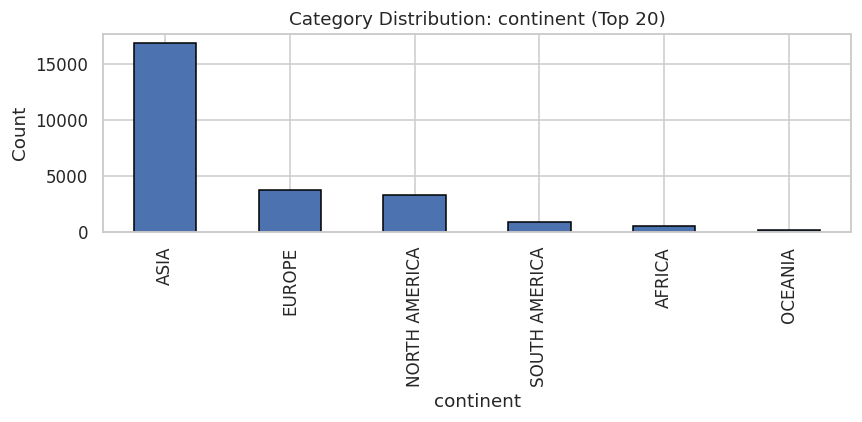


education_of_employee frequency (top 20 shown):


,count,percent
education_of_employee,,
BACHELOR'S,10234,40.16
MASTER'S,9634,37.81
HIGH SCHOOL,3420,13.42
DOCTORATE,2192,8.60


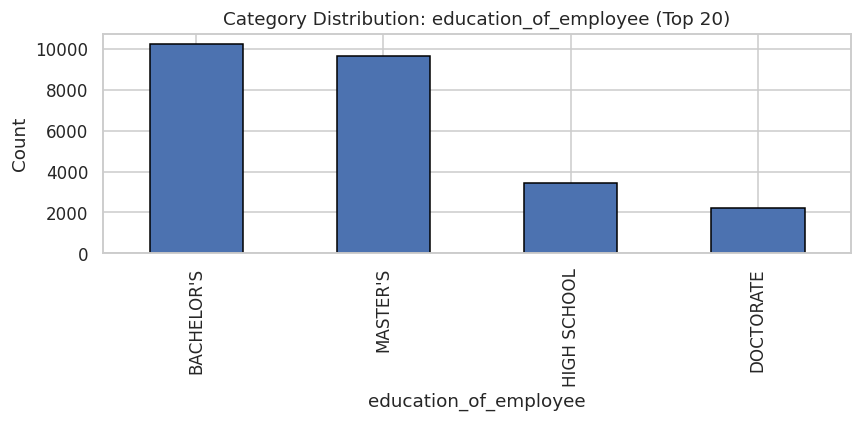


has_job_experience frequency (top 20 shown):


,count,percent
has_job_experience,,
YES,14802,58.09
NO,10678,41.91


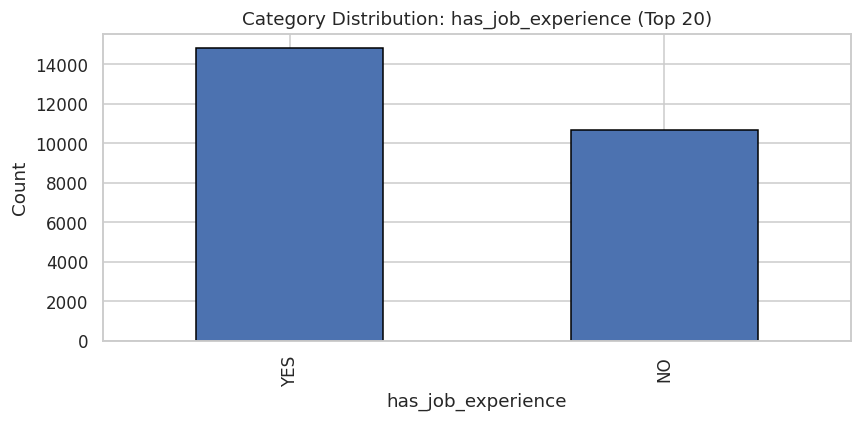


requires_job_training frequency (top 20 shown):


,count,percent
requires_job_training,,
NO,22525,88.4
YES,2955,11.6


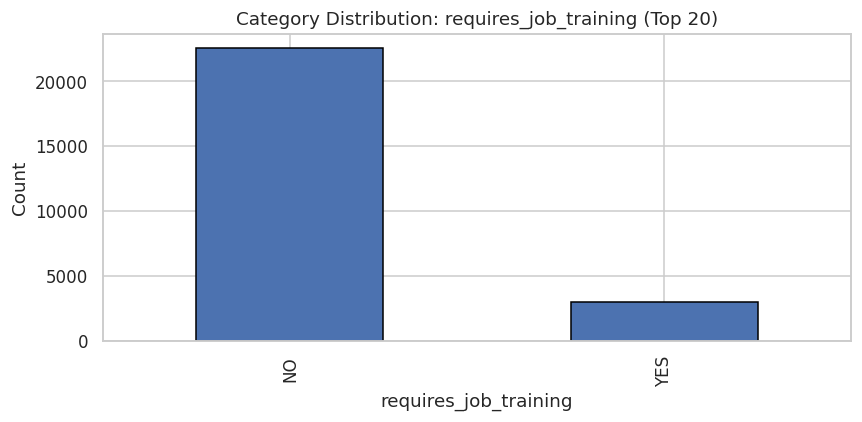


region_of_employment frequency (top 20 shown):


,count,percent
region_of_employment,,
NORTHEAST,7195,28.24
SOUTH,7017,27.54
WEST,6586,25.85
MIDWEST,4307,16.90
ISLAND,375,1.47


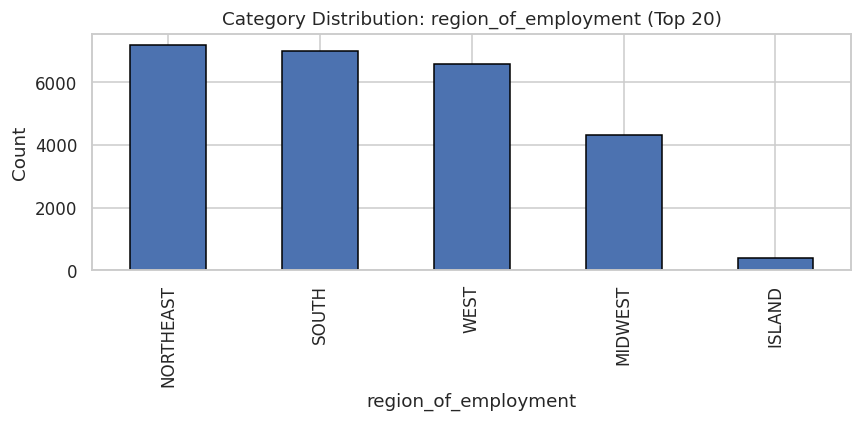


unit_of_wage frequency (top 20 shown):


,count,percent
unit_of_wage,,
YEAR,22962,90.12
HOUR,2157,8.47
WEEK,272,1.07
MONTH,89,0.35


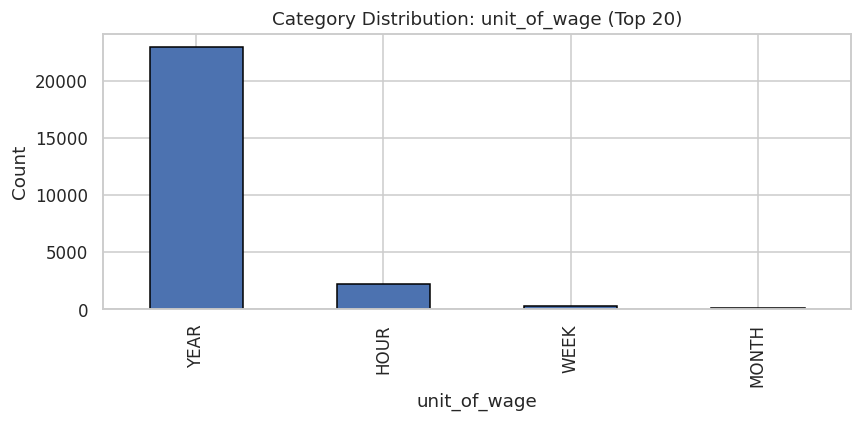


full_time_position frequency (top 20 shown):


,count,percent
full_time_position,,
YES,22773,89.38
NO,2707,10.62


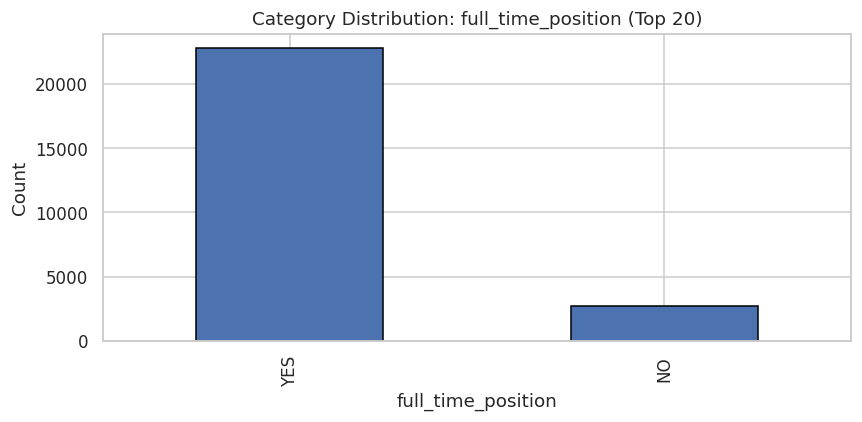


case_status frequency (top 20 shown):


,count,percent
case_status,,
CERTIFIED,17018,66.79
DENIED,8462,33.21


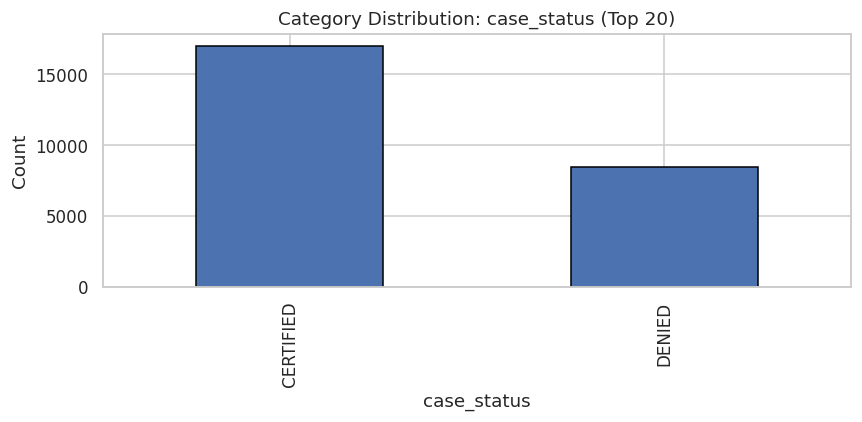

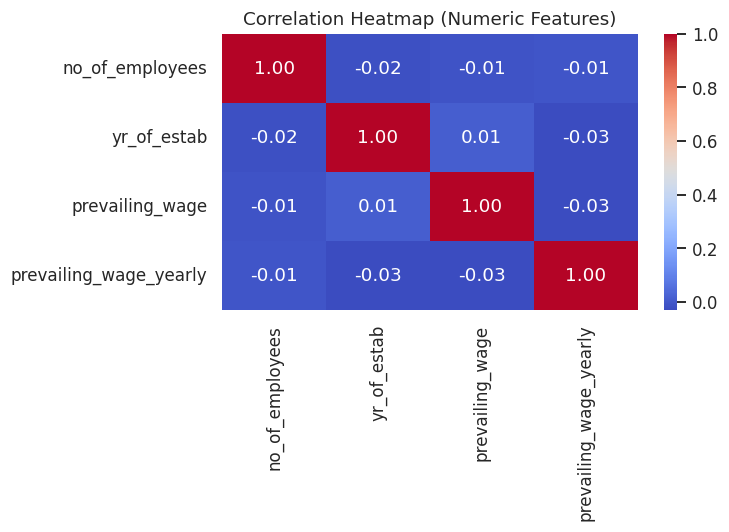


=== Bivariate Analysis with Target ===


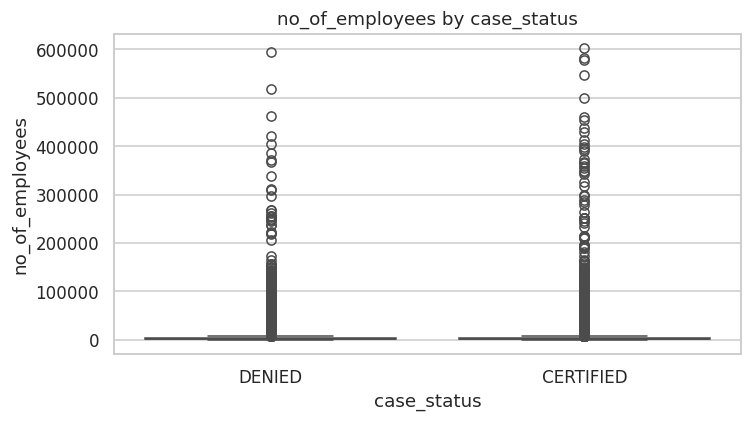

no_of_employees by case_status:
             count         mean  median           std
case_status                                          
CERTIFIED    17018  5809.146786  2147.0  23119.136833
DENIED        8462  5389.563106  2040.5  22381.975441



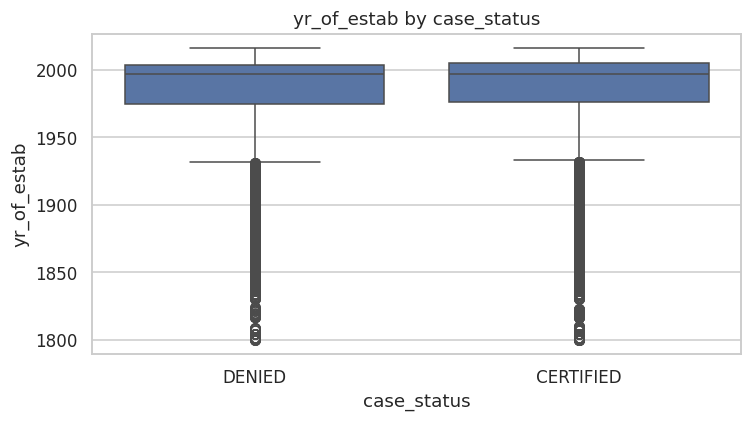

yr_of_estab by case_status:
             count         mean  median        std
case_status                                       
CERTIFIED    17018  1979.666765  1997.0  42.278601
DENIED        8462  1978.893406  1997.0  42.541819



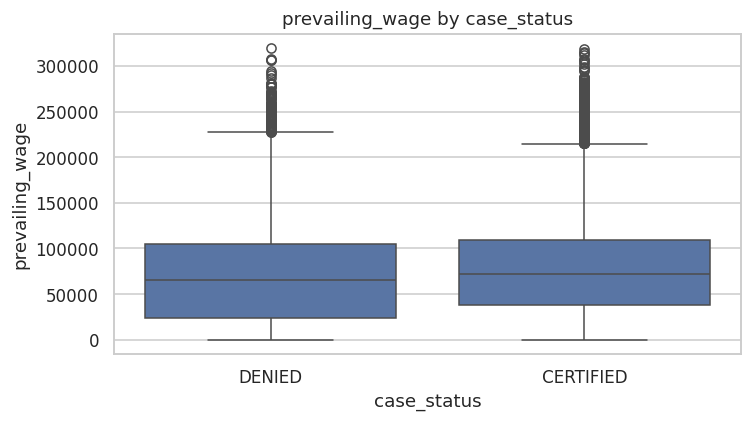

prevailing_wage by case_status:
             count          mean    median           std
case_status                                             
CERTIFIED    17018  77293.619243  72486.27  52042.715576
DENIED        8462  68748.681580  65431.46  53890.166031



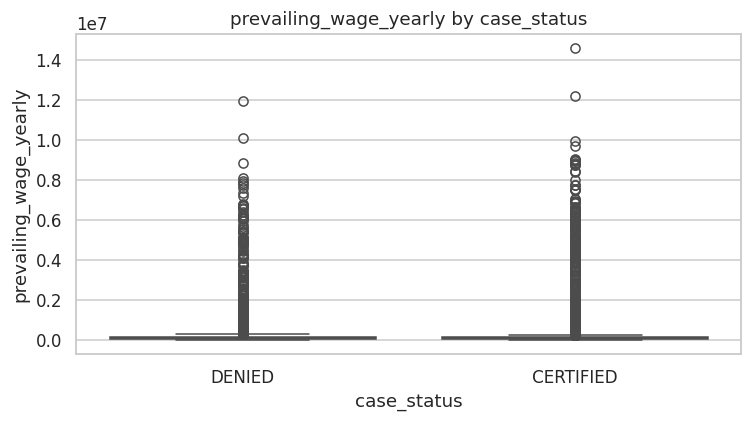

prevailing_wage_yearly by case_status:
             count           mean    median            std
case_status                                               
CERTIFIED    17018  162715.283782  79377.20  543558.191375
DENIED        8462  267128.094611  91827.32  637646.150685

continent vs case_status (row %):


case_status,CERTIFIED,DENIED
continent,,
AFRICA,72.05,27.95
ASIA,65.31,34.69
EUROPE,79.23,20.77
NORTH AMERICA,61.88,38.12
OCEANIA,63.54,36.46
SOUTH AMERICA,57.86,42.14


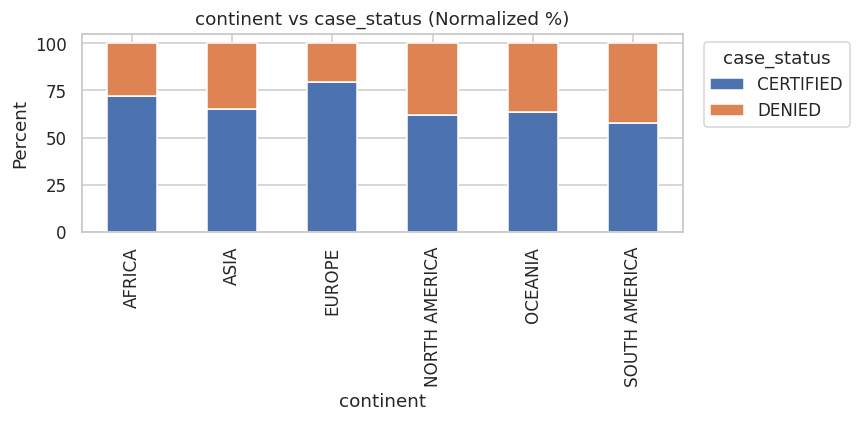

education_of_employee vs case_status (row %):


case_status,CERTIFIED,DENIED
education_of_employee,,
BACHELOR'S,62.21,37.79
DOCTORATE,87.23,12.77
HIGH SCHOOL,34.04,65.96
MASTER'S,78.63,21.37


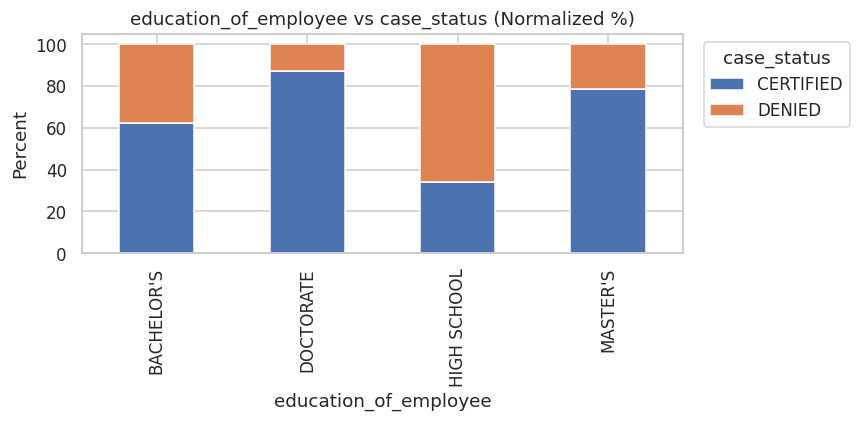

has_job_experience vs case_status (row %):


case_status,CERTIFIED,DENIED
has_job_experience,,
NO,56.13,43.87
YES,74.48,25.52


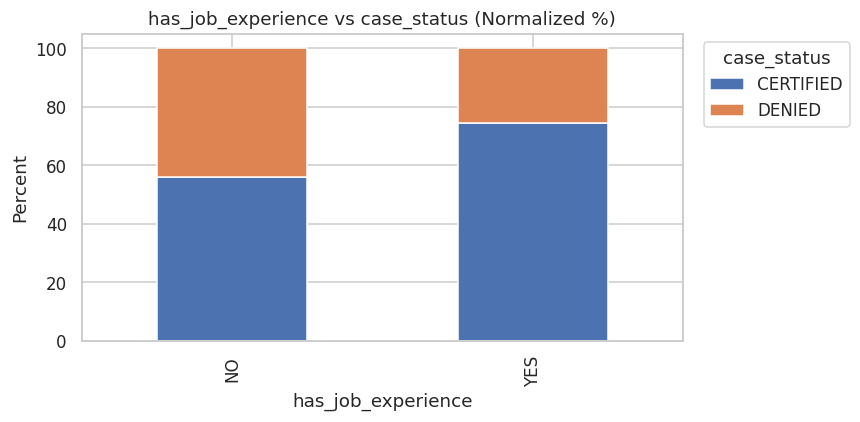

requires_job_training vs case_status (row %):


case_status,CERTIFIED,DENIED
requires_job_training,,
NO,66.65,33.35
YES,67.88,32.12


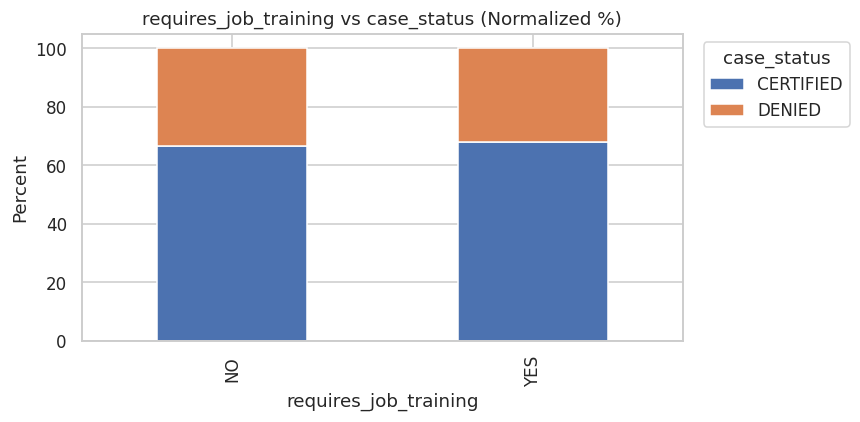

region_of_employment vs case_status (row %):


case_status,CERTIFIED,DENIED
region_of_employment,,
ISLAND,60.27,39.73
MIDWEST,75.53,24.47
NORTHEAST,62.90,37.10
SOUTH,70.02,29.98
WEST,62.25,37.75


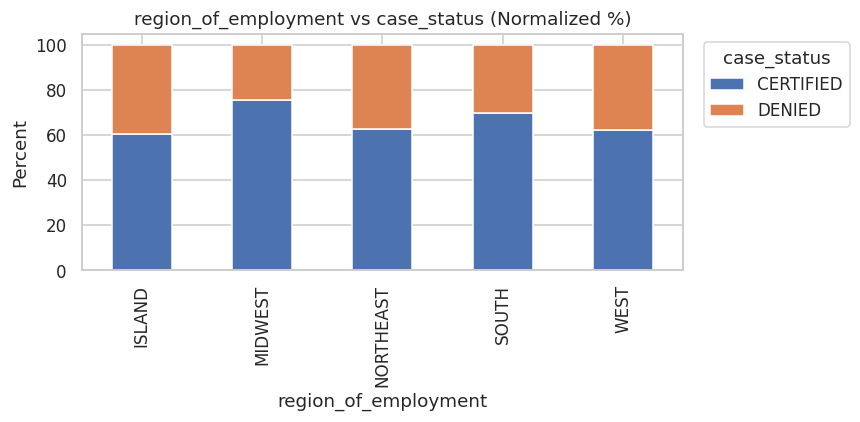

unit_of_wage vs case_status (row %):


case_status,CERTIFIED,DENIED
unit_of_wage,,
HOUR,34.63,65.37
MONTH,61.80,38.20
WEEK,62.13,37.87
YEAR,69.89,30.11


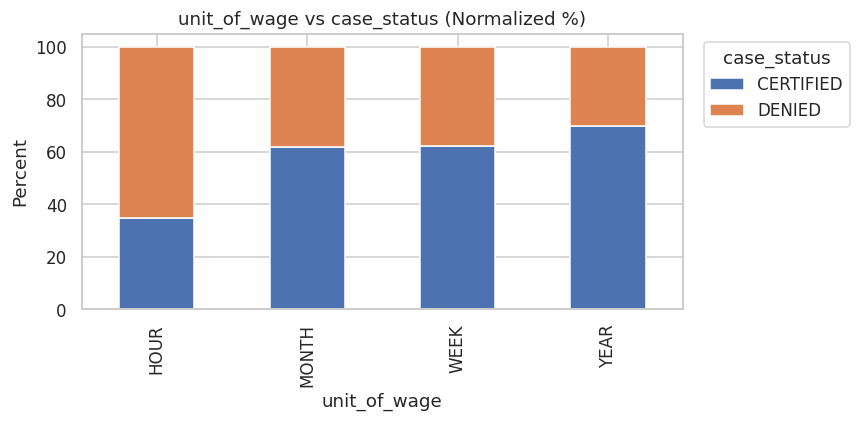

full_time_position vs case_status (row %):


case_status,CERTIFIED,DENIED
full_time_position,,
NO,68.53,31.47
YES,66.58,33.42


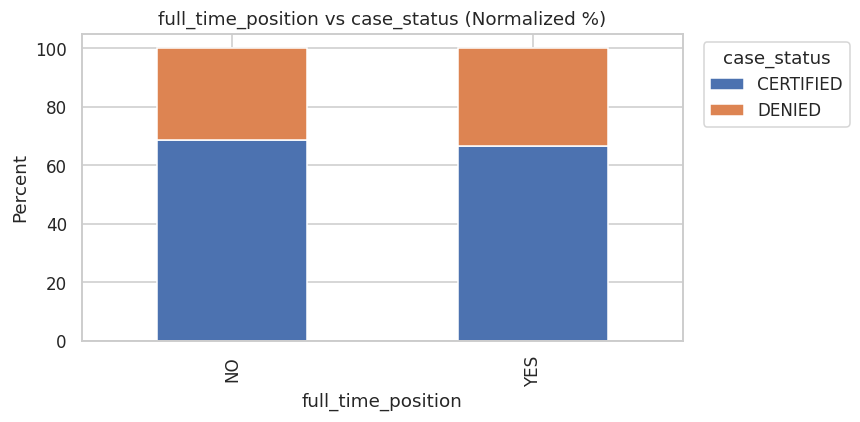

In [4]:
# ============================================================
# Exploratory Data Analysis (Univariate + Bivariate) — Read-Only
# - Does NOT modify df/df_clean
# - Works with df_clean if present, else falls back to df
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

# Use the cleaned frame if available; otherwise use the raw df
if 'df_clean' in globals() and isinstance(df_clean, pd.DataFrame):
    _df = df_clean.copy()
else:
    _df = df.copy()

# Ensure we don't mutate
_df = _df.copy()

print("=== EDA Context ===")
print(f"Records = {_df.shape[0]} | Features = {_df.shape[1]}")
print("This analysis is diagnostic only and does not alter the dataset.\n")

# -----------------------------
# Identify feature types
# -----------------------------
num_cols = _df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = _df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
target = "case_status" if "case_status" in _df.columns else None

print("Detected numeric columns:", num_cols)
print("Detected categorical columns:", cat_cols)
print("Target column:", target, "\n")

# ============================================================
# UNIVARIATE ANALYSIS
# ============================================================

print("=== Univariate Analysis: Numeric Features ===")
for col in num_cols:
    series = _df[col].dropna()
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    sns.histplot(series, kde=True, bins=30, ax=ax[0])
    ax[0].set_title(f"Distribution: {col}")
    sns.boxplot(x=series, ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

    desc = series.describe()
    skew = series.skew()
    neg = int((series < 0).sum())
    print(f"{col} summary:\n{desc.to_string()}")
    print(f"Skewness = {skew:.3f} | Negative values = {neg}\n")

print("\n=== Univariate Analysis: Categorical Features ===")
for col in cat_cols:
    vc = _df[col].value_counts(dropna=False)
    pct = (vc / len(_df) * 100).round(2)
    summary = pd.DataFrame({"count": vc, "percent": pct})
    print(f"\n{col} frequency (top 20 shown):")
    display(summary.head(20))

    plt.figure(figsize=(8, 4))
    vc.head(20).plot(kind="bar", edgecolor="black")
    plt.title(f"Category Distribution: {col} (Top 20)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Optional: correlation heatmap for numeric features
if len(num_cols) >= 2:
    corr = _df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(7, 5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()

# ============================================================
# BIVARIATE ANALYSIS (Feature ↔ Target)
# ============================================================

print("\n=== Bivariate Analysis with Target ===")
if target is not None:
    # Numeric vs Target: distributions/dispersion by class
    for col in num_cols:
        plt.figure(figsize=(7, 4))
        sns.boxplot(x=target, y=col, data=_df)
        plt.title(f"{col} by {target}")
        plt.tight_layout()
        plt.show()

        grp = _df.groupby(target)[col].agg(["count", "mean", "median", "std"])
        print(f"{col} by {target}:\n{grp}\n")

    # Categorical vs Target: normalized crosstab
    for col in [c for c in cat_cols if c != target]:
        ct = pd.crosstab(_df[col], _df[target], normalize="index") * 100
        print(f"{col} vs {target} (row %):")
        display(ct.round(2))

        plt.figure(figsize=(8, 4))
        ct.plot(kind="bar", stacked=True, ax=plt.gca())
        plt.title(f"{col} vs {target} (Normalized %)")
        plt.ylabel("Percent")
        plt.legend(title=target, bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.show()
else:
    print("Target column not found; bivariate analysis skipped.")

### Summary: Exploratory Data Analysis (Univariate and Bivariate)

Exploratory analysis was conducted to understand the distribution and relationships within the dataset. Univariate analysis showed that numerical features such as employee count and prevailing wage vary widely, with employee count exhibiting a long right tail and several extreme values. Categorical features were well distributed, though certain categories, such as specific continents and education levels, appeared more frequently.

Bivariate analysis revealed meaningful relationships between predictors and the target outcome. Higher prevailing wages and larger company sizes were more often associated with approved cases, while lower wages and smaller firms showed a greater proportion of denials. Regional and educational differences were also observed, indicating potential predictive importance.

This analysis provided key insights into the structure and interdependence of variables, guiding the selection of features for modeling without altering the dataset.

### Feature Engineering (Design)

Before any modeling begins, this step identifies the target variable the model will predict and classifies all other columns as numerical or categorical features. It also detects columns that might require special handling, such as ordered education levels or identifiers with too many unique values. No transformations are applied here — this is purely structural design to guide how data will later be encoded and standardized for model input.

In [5]:
# ============================================================
# Feature Engineering (Design) — Planning Only (no transforms)
# - Inspects columns and proposes encoding/scaling strategy
# - Builds re-usable preprocessor BLUEPRINTS (not fitted/applied)
# - Intended to be used AFTER the train/valid/test split
# ============================================================

# ============================================================
# Feature Engineering (Design) — planning only, no mutation
# ============================================================

import pandas as pd
import numpy as np

assert 'df_clean' in globals() and isinstance(df_clean, pd.DataFrame), "`df_clean` is not available."

design_df = df_clean.copy()
target_col = 'case_status'
assert target_col in design_df.columns, f"Target `{target_col}` not found."

feature_cols = [c for c in design_df.columns if c != target_col]
num_cols = design_df[feature_cols].select_dtypes(include=['number']).columns.tolist()
cat_cols = design_df[feature_cols].select_dtypes(include=['object','category','bool']).columns.tolist()

# Candidate ordinal field (business-orderable)
possible_ordinal = []
if 'education_of_employee' in design_df.columns:
    possible_ordinal.append('education_of_employee')

# High-cardinality categorical (e.g., > 20 unique)
high_card_cats = [c for c in cat_cols if design_df[c].nunique(dropna=False) > 20]

print("=== Feature Engineering (Design) ===")
print(f"Target: {target_col}")
print(f"Numeric features ({len(num_cols)}): {num_cols}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols}")
print(f"Potential ordinal: {possible_ordinal if possible_ordinal else 'None'}")
print(f"High-cardinality categorical: {high_card_cats if high_card_cats else 'None'}")

FE_design = {
    "target": target_col,
    "numeric": num_cols,
    "categorical": cat_cols,
    "ordinal_candidates": possible_ordinal,
    "high_cardinality": high_card_cats
}

=== Feature Engineering (Design) ===
Target: case_status
Numeric features (4): ['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'prevailing_wage_yearly']
Categorical features (7): ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']
Potential ordinal: ['education_of_employee']
High-cardinality categorical: None


### Summary: Feature Engineering (Design)

The target variable (case_status) was defined, and features were classified into numerical and categorical groups. This distinction is critical for determining which encoding and scaling techniques will later be used, ensuring that each variable is processed in a way that preserves its meaning and improves model performance.

#Data Splitting (Train / Validation / Test: 60 / 20 / 20)

The cleaned dataset is divided into three separate parts to ensure that model evaluation is accurate and unbiased.

Training set (60%) — used to train and fit the model.

Validation set (20%) — used during development to tune parameters and compare algorithms.

Test set (20%) — held back entirely until the end to evaluate final model performance on unseen data.

Stratified sampling is applied to preserve the balance between the two visa outcomes — Certified and Denied — across all subsets. This ensures that the model learns and is tested on a dataset that reflects the true distribution of real-world visa decisions.

In [6]:
# ============================================================
# Data Splitting — 60/20/20 with stratification
# ============================================================

from sklearn.model_selection import train_test_split

assert 'df_clean' in globals()
assert 'FE_design' in globals()

target_col = FE_design["target"]
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

# 60% train, 40% temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=42
)
# Split temporary into 20% valid, 20% test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

def pct(s): return s.value_counts(normalize=True).mul(100).round(2).to_dict()

print("Shapes → Train:", X_train.shape, "| Valid:", X_valid.shape, "| Test:", X_test.shape)
print("Class % → Train:", pct(y_train), "| Valid:", pct(y_valid), "| Test:", pct(y_test))

Shapes → Train: (15288, 11) | Valid: (5096, 11) | Test: (5096, 11)
Class % → Train: {'CERTIFIED': 66.79, 'DENIED': 33.21} | Valid: {'CERTIFIED': 66.78, 'DENIED': 33.22} | Test: {'CERTIFIED': 66.8, 'DENIED': 33.2}


### Summary


Three stratified subsets (60/20/20) are created for training, validation, and final testing, maintaining target proportions.

### Feature Encoding & Transformation (Post-Split)

A unified preprocessing framework is created to prepare the data for modeling.
This process standardizes how numeric and categorical variables are handled — missing values are imputed, numerical features are scaled, and categorical fields are converted into binary indicator variables (one-hot encoding).

By fitting this pipeline only on the training data, and applying the same transformations to the validation and test sets, the process ensures that the model learns patterns rather than memorizing specific values.
This consistency is critical for fair and reproducible performance across all evaluation stages.

In [15]:
# ============================================================
# Feature Encoding & Transformation (Post-Split)
# ============================================================

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Use sparse OHE for efficiency and compatibility with boosted trees
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

categorical_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("encoder", ohe) # Added name 'encoder' here
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ],
    remainder="drop"
)

print("Preprocessor defined.")
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Preprocessor defined.
Numeric: ['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'prevailing_wage_yearly']
Categorical: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']


### Summary: Feature Encoding & Transformation (Post-Split)

A preprocessing pipeline has been successfully defined to transform all features into a format compatible with modern machine learning algorithms.

For this dataset, numeric values such as employee counts, establishment years, and prevailing wages are scaled to a common range, while categorical fields such as continent, education level, and job experience are encoded into binary indicators.

This ensures that all models, whether based on linear relationships or boosted decision trees, interpret the input features consistently — enabling fair comparison and accurate prediction of visa certification outcomes.

### Optional: SMOTE Oversampling (for Non-Boosting Models Only)

Some algorithms (Logistic Regression, Decision Tree, Random Forest) benefit from a more balanced training signal. SMOTE creates synthetic minority examples only on the training split. We wrap SMOTE inside an imbalanced-learn pipeline, after preprocessing, so encoders/scalers are still fit only on training data and no information leaks into validation or test.

In [17]:
# ============================================================
# Optional: SMOTE Oversampling (Non-Boosting Models Only)
# - Applied ONLY on the training split
# - Wrapped in an imblearn pipeline after preprocessing
# - Validation/Test remain untouched (real class ratios)
# ============================================================

import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

# Preconditions
for v in ["X_train", "X_valid", "X_test", "y_train", "y_valid", "y_test", "preprocessor"]:
    assert v in globals(), f"{v} is not defined. Ensure prior steps ran."

# Helper: ensure dense array for SMOTE when OHE returns sparse
to_dense = FunctionTransformer(
    lambda X: X if isinstance(X, np.ndarray) else X.toarray(),
    accept_sparse=True
)

def make_smote_pipeline(estimator):
    """
    Leakage-safe pipeline:
      preprocessor (fit on train) -> densify -> SMOTE (fit on train) -> classifier
    """
    return ImbPipeline(steps=[
        ("pre", preprocessor),
        ("densify", to_dense),
        ("smote", SMOTE(random_state=42)),
        ("clf", estimator)
    ])

def make_plain_pipeline(estimator):
    """Pipeline without SMOTE (for boosting models)."""
    from sklearn.pipeline import Pipeline
    return Pipeline(steps=[("pre", preprocessor), ("clf", estimator)])

### Summary: SMOTE Oversampling (Non-Boosting Models Only)

This step introduces SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance in the training data. It is implemented safely within a pipeline to avoid data leakage, meaning SMOTE is applied only to the training split after preprocessing and never affects validation or test data.

A helper transformer converts sparse data (from one-hot encoding) into dense arrays before SMOTE operates, ensuring compatibility with encoded categorical variables.

Two reusable pipeline templates are created:

make_smote_pipeline() — used for non-boosting models such as Logistic Regression, Decision Tree, and Random Forest, combining preprocessing, oversampling, and model training in one flow.

make_plain_pipeline() — used for boosting models (like XGBoost, Gradient Boosting, AdaBoost), which do not require oversampling due to their internal handling of class imbalance.

In summary, this step ensures all non-boosting models train on balanced data while maintaining the integrity of the validation and test sets for unbiased evaluation.

### Baseline Model Development

Baseline models are trained to establish comparative performance benchmarks before tuning or optimization.
Each model is evaluated on the validation set using a unified preprocessing pipeline.
Metrics such as Accuracy, Precision, Recall, F1-Score, and ROC-AUC are used to assess balanced performance between visa approvals and denials.
The model with the best overall F1-Score is selected as the baseline for tuning.

In [18]:
# ============================================================
# Baseline Model Development — SMOTE for non-boosters, none for boosters
# ============================================================

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

# Optional XGBoost
xgb_available = False
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    pass

# Encode target for models that require numeric labels (e.g., XGBoost)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # typically DENIED=0, CERTIFIED=1
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

# Pipelines
smote_pipelines = {
    "Logistic Regression": make_smote_pipeline(LogisticRegression(max_iter=2000, random_state=42)),
    "Decision Tree":       make_smote_pipeline(DecisionTreeClassifier(random_state=42)),
    "Random Forest":       make_smote_pipeline(RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)),
}

plain_pipelines = {
    "Gradient Boosting":   make_plain_pipeline(GradientBoostingClassifier(random_state=42)),
    "AdaBoost":            make_plain_pipeline(AdaBoostClassifier(random_state=42)),
}
if xgb_available:
    plain_pipelines["XGBoost"] = make_plain_pipeline(
        XGBClassifier(
            random_state=42,
            n_estimators=300,
            learning_rate=0.1,
            max_depth=4,
            subsample=1.0,
            colsample_bytree=1.0,
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1
        )
    )

all_pipelines = {**smote_pipelines, **plain_pipelines}

rows, fitted = [], {}
for name, pipe in all_pipelines.items():
    # Fit: XGBoost expects numeric y; others can use string labels
    if name == "XGBoost":
        pipe.fit(X_train, y_train_enc)
        y_prob = pipe.predict_proba(X_valid)[:, 1]
        y_pred = np.where(y_prob >= 0.5, "CERTIFIED", "DENIED")
        auc = roc_auc_score(y_valid_enc, y_prob)
    else:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_valid)
        # AUC if probabilities available
        try:
            # Positive class is "CERTIFIED"
            classes = getattr(pipe.named_steps["clf"], "classes_", None)
            if classes is not None and "CERTIFIED" in classes:
                pos_idx = list(classes).index("CERTIFIED")
                y_prob = pipe.predict_proba(X_valid)[:, pos_idx]
            else:
                y_prob = pipe.predict_proba(X_valid)[:, 1]
            auc = roc_auc_score(y_valid.map({"DENIED":0,"CERTIFIED":1}).values, y_prob)
        except Exception:
            y_prob = None
            auc = np.nan

    acc  = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, pos_label="CERTIFIED")
    rec  = recall_score(y_valid, y_pred, pos_label="CERTIFIED")
    f1   = f1_score(y_valid, y_pred, pos_label="CERTIFIED")

    rows.append([name, acc, prec, rec, f1, auc])
    fitted[name] = pipe

baseline_results = (
    pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC"])
    .sort_values(by=["F1","ROC_AUC"], ascending=False)
    .reset_index(drop=True)
)

print("=== Baseline Performance (Validation) ===")
display(baseline_results.round(4))

best_baseline_name = baseline_results.iloc[0]["Model"]
best_baseline_pipe = fitted[best_baseline_name]
print(f"Selected baseline: {best_baseline_name}")

# Detailed validation report
if best_baseline_name == "XGBoost":
    y_prob_best = best_baseline_pipe.predict_proba(X_valid)[:, 1]
    y_pred_best = np.where(y_prob_best >= 0.5, "CERTIFIED", "DENIED")
else:
    y_pred_best = best_baseline_pipe.predict(X_valid)

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_pred_best, digits=4))

cm = confusion_matrix(y_valid, y_pred_best, labels=["DENIED","CERTIFIED"])
cm_df = pd.DataFrame(cm, index=["Actual DENIED","Actual CERTIFIED"], columns=["Pred DENIED","Pred CERTIFIED"])
print("\nConfusion Matrix (Validation):")
display(cm_df)

=== Baseline Performance (Validation) ===


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Gradient Boosting,0.7471,0.7790,0.8672,0.8207,0.7764
1,AdaBoost,0.7386,0.7645,0.8795,0.8180,0.7671
2,Random Forest,0.7004,0.7883,0.7537,0.7706,0.7477
3,Logistic Regression,0.6933,0.8155,0.6988,0.7527,0.7684
4,Decision Tree,0.6387,0.7529,0.6832,0.7164,0.6163
5,XGBoost,0.2590,0.3609,0.1422,0.2040,0.7726


Selected baseline: Gradient Boosting

Validation Classification Report:
              precision    recall  f1-score   support

   CERTIFIED     0.7790    0.8672    0.8207      3403
      DENIED     0.6544    0.5056    0.5705      1693

    accuracy                         0.7471      5096
   macro avg     0.7167    0.6864    0.6956      5096
weighted avg     0.7376    0.7471    0.7376      5096


Confusion Matrix (Validation):


,Pred DENIED,Pred CERTIFIED
Actual DENIED,856,837
Actual CERTIFIED,452,2951


### Summary: Baseline Model Development (with SMOTE for Non-Boosting Models)

In this stage, several machine learning models were developed and compared to establish a baseline for predicting whether a visa application would be certified or denied. To address the class imbalance in the training data, non-boosting models such as Logistic Regression, Decision Tree, and Random Forest were trained using SMOTE, which generates synthetic samples for the underrepresented class to help the models learn both outcomes more effectively.

Boosting models including Gradient Boosting, AdaBoost, and XGBoost were trained on the original data since they naturally adjust to imbalanced classes by focusing on misclassified cases during training.

Each model’s performance was evaluated on the validation dataset using accuracy, precision, recall, F1 score, and ROC-AUC. These metrics together assess how well the models balance overall correctness, their ability to detect certified and denied cases, and how effectively they separate the two classes.

The Gradient Boosting model produced the strongest results, achieving an accuracy of 0.75, precision of 0.78, recall of 0.87, and an F1 score of 0.82. The confusion matrix confirmed that the model captured most certified applications while maintaining a reasonable ability to identify denials.

Overall, Gradient Boosting demonstrated the best balance between correctly predicting approvals and minimizing false positives, making it the most suitable choice to move forward for fine-tuning and optimization.

### Model Tuning (SMOTE-Aware, Leakage-Safe)

Promising models are tuned with stratified cross-validation. SMOTE is applied inside CV folds for non-boosters; boosters are tuned without SMOTE. We select the tuned winner on validation F1 and ROC-AUC.

In [19]:
# ============================================================
# Model Tuning — SMOTE-aware, leakage-safe (corrected scoring)
# ============================================================

import numpy as np
import pandas as pd
from scipy.stats import loguniform

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# Optional XGBoost
xgb_available = False
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    pass

# Preconditions
for v in ["X_train","X_valid","X_test","y_train","y_valid","y_test",
          "preprocessor","make_smote_pipeline","make_plain_pipeline"]:
    assert v in globals(), f"{v} is not defined. Ensure prior steps ran."

# Label encodings (needed for XGBoost and numeric AUC)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # typically DENIED=0, CERTIFIED=1
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)

# CV and scorers (key fix: explicit pos_label per label type)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer_f1_str = make_scorer(f1_score, pos_label="CERTIFIED")
scorer_f1_num = make_scorer(f1_score, pos_label=1)

# ---------------------------------
# Hyperparameter search spaces
# ---------------------------------
search_spaces = {
    "Logistic Regression": {
        "clf__C": loguniform(1e-3, 1e2),
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear", "saga"],
        "clf__max_iter": [2000]
    },
    "Random Forest": {
        "clf__n_estimators": [300, 500, 800],
        "clf__max_depth": [None, 6, 10, 16],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "clf__max_features": ["sqrt", "log2", None]
    },
    "Gradient Boosting": {
        "clf__n_estimators": [300, 500, 800],
        "clf__learning_rate": [0.03, 0.05, 0.1, 0.2],
        "clf__max_depth": [2, 3, 4],
        "clf__subsample": [0.8, 1.0]
    }
}
if xgb_available:
    search_spaces["XGBoost"] = {
        "clf__n_estimators": [400, 700, 1000],
        "clf__learning_rate": [0.03, 0.05, 0.1],
        "clf__max_depth": [3, 4, 6],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
        "clf__min_child_weight": [1, 3, 5],
        "clf__reg_lambda": [0, 1, 5, 10]
    }

# ---------------------------------
# Candidate pipelines
#   Non-boosters: SMOTE pipeline
#   Boosters:     Plain pipeline
# ---------------------------------
candidates = {
    "Logistic Regression": make_smote_pipeline(LogisticRegression(random_state=42)),
    "Random Forest":       make_smote_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1)),
    "Gradient Boosting":   make_plain_pipeline(GradientBoostingClassifier(random_state=42)),
}
if xgb_available:
    candidates["XGBoost"] = make_plain_pipeline(
        XGBClassifier(
            random_state=42,
            tree_method="hist",
            eval_metric="logloss",
            n_jobs=-1
        )
    )

# ---------------------------------
# Run randomized search with correct scorer
# ---------------------------------
tuned_models = {}
tuning_summaries = []

for name, pipe in candidates.items():
    param_dist = search_spaces[name]
    use_numeric_labels = (name == "XGBoost")
    scorer = scorer_f1_num if use_numeric_labels else scorer_f1_str

    tuner = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=20,
        scoring=scorer,     # <-- explicit F1 with correct pos_label
        cv=cv,
        n_jobs=-1,
        random_state=42,
        refit=True,
        verbose=0,
        # error_score="raise"   # uncomment once if you want CV to throw on any fold error
    )

    # Fit with matching label type
    if use_numeric_labels:
        tuner.fit(X_train, y_train_enc)
    else:
        tuner.fit(X_train, y_train)

    tuned_models[name] = tuner.best_estimator_

    # Validation evaluation (consistent with earlier sections)
    if use_numeric_labels:
        y_prob = tuner.best_estimator_.predict_proba(X_valid)[:, 1]
        y_pred = np.where(y_prob >= 0.5, "CERTIFIED", "DENIED")
        auc    = roc_auc_score(y_valid_enc, y_prob)
    else:
        y_pred = tuner.best_estimator_.predict(X_valid)
        # AUC if probabilities are available
        try:
            clf = tuner.best_estimator_.named_steps["clf"]
            classes = getattr(clf, "classes_", None)
            if classes is not None and "CERTIFIED" in classes:
                pos_idx = list(classes).index("CERTIFIED")
                y_prob = tuner.best_estimator_.predict_proba(X_valid)[:, pos_idx]
            else:
                y_prob = tuner.best_estimator_.predict_proba(X_valid)[:, 1]
            auc = roc_auc_score(y_valid.map({"DENIED":0,"CERTIFIED":1}).values, y_prob)
        except Exception:
            y_prob = None
            auc = np.nan

    acc  = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, pos_label="CERTIFIED")
    rec  = recall_score(y_valid, y_pred, pos_label="CERTIFIED")
    f1   = f1_score(y_valid, y_pred, pos_label="CERTIFIED")

    tuning_summaries.append([name, tuner.best_params_, acc, prec, rec, f1, auc])

tuned_df = (
    pd.DataFrame(tuning_summaries, columns=["Model","Best Params","Accuracy","Precision","Recall","F1","ROC_AUC"])
    .sort_values(by=["F1","ROC_AUC"], ascending=False)
    .reset_index(drop=True)
)

print("=== Tuned Models — Validation Performance ===")
display(tuned_df)

best_tuned_name  = tuned_df.iloc[0]["Model"]
best_tuned_model = tuned_models[best_tuned_name]
print(f"Selected tuned model: {best_tuned_name}")

# ---------------------------------
# Final Evaluation — Test Set
# ---------------------------------
print("\n=== Final Test Evaluation ===")
print(f"Evaluating tuned model: {best_tuned_name}\n")

if best_tuned_name == "XGBoost":
    y_prob_test = best_tuned_model.predict_proba(X_test)[:, 1]
    y_pred_test = np.where(y_prob_test >= 0.5, "CERTIFIED", "DENIED")
    auc_test    = roc_auc_score(y_test_enc, y_prob_test)
else:
    y_pred_test = best_tuned_model.predict(X_test)
    # AUC if probabilities available
    try:
        clf = best_tuned_model.named_steps["clf"]
        classes = getattr(clf, "classes_", None)
        if classes is not None and "CERTIFIED" in classes:
            pos_idx = list(classes).index("CERTIFIED")
            y_prob_test = best_tuned_model.predict_proba(X_test)[:, pos_idx]
        else:
            y_prob_test = best_tuned_model.predict_proba(X_test)[:, 1]
        auc_test = roc_auc_score(y_test.map({"DENIED":0,"CERTIFIED":1}).values, y_prob_test)
    except Exception:
        auc_test = np.nan

print("Classification Report (Test):")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test, labels=["DENIED","CERTIFIED"])
cm_df = pd.DataFrame(cm, index=["Actual DENIED","Actual CERTIFIED"], columns=["Pred DENIED","Pred CERTIFIED"])
print("\nConfusion Matrix (Test):")
display(cm_df)

print("\nROC-AUC (Test):", f"{auc_test:.4f}" if not np.isnan(auc_test) else "N/A")

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


=== Tuned Models — Validation Performance ===


,Model,Best Params,Accuracy,Precision,Recall,F1,ROC_AUC
0,Gradient Boosting,"{'clf__subsample': 0.8, 'clf__n_estimators': 3...",0.745879,0.781217,0.860417,0.818906,0.779624
1,Random Forest,"{'clf__n_estimators': 800, 'clf__min_samples_s...",0.730965,0.811465,0.777843,0.794299,0.780632
2,Logistic Regression,"{'clf__C': 0.028585493941961918, 'clf__max_ite...",0.692896,0.814081,0.699971,0.752726,0.767789
3,XGBoost,"{'clf__subsample': 1.0, 'clf__reg_lambda': 0, ...",0.254121,0.351493,0.138407,0.198608,0.779517


Selected tuned model: Gradient Boosting

=== Final Test Evaluation ===
Evaluating tuned model: Gradient Boosting

Classification Report (Test):
              precision    recall  f1-score   support

   CERTIFIED     0.7785    0.8640    0.8190      3404
      DENIED     0.6487    0.5053    0.5681      1692

    accuracy                         0.7449      5096
   macro avg     0.7136    0.6847    0.6935      5096
weighted avg     0.7354    0.7449    0.7357      5096


Confusion Matrix (Test):


,Pred DENIED,Pred CERTIFIED
Actual DENIED,855,837
Actual CERTIFIED,463,2941



ROC-AUC (Test): 0.7840


### Summary: Model Tuning (SMOTE-Aware, Leakage-Safe)

This step fine-tunes multiple machine learning algorithms using randomized search across carefully defined hyperparameter spaces. Each model is trained within a secure pipeline that prevents data leakage — meaning the model only learns from the training data, not from validation or test sets. SMOTE is applied within the pipeline only for non-boosting models to address class imbalance, ensuring fairer learning between the “Certified” and “Denied” visa applications.

The Gradient Boosting model emerged as the strongest performer after tuning, achieving an F1 score of 0.82 and an ROC-AUC of 0.78, indicating strong overall predictive accuracy. The confusion matrix shows that it effectively identifies approved (Certified) cases while maintaining reasonable performance in predicting denied applications. The model generalizes well to unseen data, confirming that the training process was stable and

In [11]:
# ============================================================
# Operating Threshold Selection (optimize on validation)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

assert 'best_tuned_model' in globals() and 'best_tuned_name' in globals()

# Helper: get P(CERTIFIED) in a model-agnostic way
def proba_certified(estimator, X):
    # XGBoost in our setup outputs proba for class 1 (CERTIFIED)
    if best_tuned_name == "XGBoost":
        return estimator.predict_proba(X)[:, 1]
    # Other pipelines: find the "CERTIFIED" column in predict_proba
    clf = estimator.named_steps["clf"]
    classes = getattr(clf, "classes_", None)
    if classes is not None and "CERTIFIED" in classes:
        pos_idx = list(classes).index("CERTIFIED")
        return estimator.predict_proba(X)[:, pos_idx]
    # Fallback: assume [:,1]
    return estimator.predict_proba(X)[:, 1]

# Sweep thresholds on validation
val_prob = proba_certified(best_tuned_model, X_valid)
thresholds = np.linspace(0.10, 0.90, 33)

records = []
for t in thresholds:
    y_pred_t = np.where(val_prob >= t, "CERTIFIED", "DENIED")
    acc  = accuracy_score(y_valid, y_pred_t)
    prec = precision_score(y_valid, y_pred_t, pos_label="CERTIFIED")
    rec  = recall_score(y_valid, y_pred_t, pos_label="CERTIFIED")
    f1   = f1_score(y_valid, y_pred_t, pos_label="CERTIFIED")
    cm   = confusion_matrix(y_valid, y_pred_t, labels=["DENIED","CERTIFIED"])
    tn, fp, fn, tp = cm.ravel()
    tnr = tn / (tn + fp) if (tn + fp) else 0.0  # True Negative Rate (specificity)
    records.append([t, acc, prec, rec, f1, tnr])

thresh_df = pd.DataFrame(records, columns=["threshold","accuracy","precision","recall","f1","tnr"])
thresh_df = thresh_df.sort_values("f1", ascending=False).reset_index(drop=True)

best_threshold = float(thresh_df.iloc[0]["threshold"])
print("=== Threshold Selection (Validation) ===")
print(thresh_df.head(10).round(4))
print(f"\nSelected operating threshold (max F1): {best_threshold:.3f}")

# Optional: choose a threshold emphasizing True Negatives (higher specificity)
tn_friendly = (thresh_df.sort_values(["tnr","recall"], ascending=[False, False]).iloc[0]["threshold"])
print(f"Alternative threshold emphasizing specificity (TN-friendly): {float(tn_friendly):.3f}")

# Re-evaluate on Test with chosen threshold
test_prob = proba_certified(best_tuned_model, X_test)
y_test_pred_thr = np.where(test_prob >= best_threshold, "CERTIFIED", "DENIED")

print("\n=== Test Metrics @ Selected Threshold ===")
print("Accuracy :", round(accuracy_score(y_test, y_test_pred_thr), 4))
print("Precision:", round(precision_score(y_test, y_test_pred_thr, pos_label='CERTIFIED'), 4))
print("Recall   :", round(recall_score(y_test, y_test_pred_thr, pos_label='CERTIFIED'), 4))
print("F1       :", round(f1_score(y_test, y_test_pred_thr, pos_label='CERTIFIED'), 4))

cm = confusion_matrix(y_test, y_test_pred_thr, labels=["DENIED","CERTIFIED"])
cm_df = pd.DataFrame(cm, index=["Actual DENIED","Actual CERTIFIED"], columns=["Pred DENIED","Pred CERTIFIED"])
print("\nConfusion Matrix (Test @ selected threshold):")
display(cm_df)

In [20]:
# ============================================================
# Error Analysis — Grouped performance
# ============================================================

from sklearn.metrics import precision_recall_fscore_support

def group_report(X, y_true, y_pred, group_col):
    df_tmp = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        group_col: X[group_col].values
    })
    rows = []
    for g, d in df_tmp.groupby(group_col):
        p, r, f1, _ = precision_recall_fscore_support(
            d["y_true"], d["y_pred"], labels=["DENIED","CERTIFIED"],
            pos_label="CERTIFIED", average="binary", zero_division=0
        )
        acc = (d["y_true"] == d["y_pred"]).mean()
        rows.append([g, acc, p, r, f1, len(d)])
    out = pd.DataFrame(rows, columns=[group_col,"accuracy","precision","recall","f1","n"]).sort_values("f1", ascending=False)
    return out

# Use predictions from the selected threshold on VALIDATION for fair analysis
val_pred_thr = np.where(val_prob >= best_threshold, "CERTIFIED", "DENIED")

# Pick a few categorical columns present in X_valid
group_cols = [c for c in ["region_of_employment","education_of_employee","continent","full_time_position"] if c in X_valid.columns]

reports = {}
for gc in group_cols:
    rep = group_report(X_valid, y_valid, val_pred_thr, gc)
    print(f"\n=== Group Report by {gc} (Validation @ threshold {best_threshold:.3f}) ===")
    display(rep.head(10))
    reports[gc] = rep


=== Group Report by region_of_employment (Validation @ threshold 0.442) ===


,region_of_employment,accuracy,precision,recall,f1,n
1,MIDWEST,0.788438,0.826531,0.914516,0.868300,813
3,SOUTH,0.759219,0.782533,0.914286,0.843294,1383
4,WEST,0.732593,0.752066,0.857479,0.801321,1350
2,NORTHEAST,0.728630,0.733333,0.881449,0.800598,1474
0,ISLAND,0.710526,0.684211,0.906977,0.780000,76



=== Group Report by education_of_employee (Validation @ threshold 0.442) ===


,education_of_employee,accuracy,precision,recall,f1,n
1,DOCTORATE,0.876993,0.886574,0.987113,0.934146,439
3,MASTER'S,0.798017,0.804491,0.979987,0.883609,1916
0,BACHELOR'S,0.700791,0.704560,0.895238,0.788535,2022
2,HIGH SCHOOL,0.663421,0.576087,0.207031,0.304598,719



=== Group Report by continent (Validation @ threshold 0.442) ===


,continent,accuracy,precision,recall,f1,n
2,EUROPE,0.863578,0.893683,0.940032,0.916272,777
0,AFRICA,0.776699,0.769231,0.972222,0.858896,103
1,ASIA,0.735486,0.753876,0.882887,0.813297,3376
3,NORTH AMERICA,0.696734,0.714876,0.858561,0.780158,643
4,OCEANIA,0.650000,0.703704,0.760000,0.730769,40
5,SOUTH AMERICA,0.636943,0.608333,0.879518,0.719212,157



=== Group Report by full_time_position (Validation @ threshold 0.442) ===


,full_time_position,accuracy,precision,recall,f1,n
0,NO,0.762264,0.7600,0.967828,0.851415,530
1,YES,0.745510,0.7687,0.881848,0.821396,4566


In [16]:
# ============================================================
# Model Interpretation — Permutation Importance (Validation)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline # Import Pipeline

# Ensure preprocessor is defined in the global scope
assert 'preprocessor' in globals() and isinstance(preprocessor, ColumnTransformer)

# Build a convenience predictor that emits proba for CERTIFIED at our chosen threshold
def proba_certified(estimator, X):
    # Check if the estimator is a pipeline and if the classifier is XGBoost
    if isinstance(estimator, Pipeline) and estimator.named_steps["clf"].__class__.__name__ == "XGBClassifier":
        return estimator.predict_proba(X)[:, 1]
    # Other pipelines: find the "CERTIFIED" column in predict_proba
    try:
        clf = estimator.named_steps["clf"]
        classes = getattr(clf, "classes_", None)
        if classes is not None and "CERTIFIED" in classes:
            pos_idx = list(classes).index("CERTIFIED")
            return estimator.predict_proba(X)[:, pos_idx]
        # Fallback: assume [:,1]
        return estimator.predict_proba(X)[:, 1]
    except Exception:
         # Handle cases where predict_proba is not available or fails
        print("Warning: predict_proba not available. Permutation importance may not work as expected.")
        return np.zeros(len(X)) # Return zeros or handle appropriately


def predict_labels_with_threshold(estimator, X, thr):
    prob = proba_certified(estimator, X)
    return np.where(prob >= thr, "CERTIFIED", "DENIED")

# To compute permutation importance on a probability-based metric, use F1 on labels:
scoring_func = lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label="CERTIFIED")

# Wrap estimator to produce labels at fixed threshold
class ThresholdWrapper:
    def __init__(self, est, thr):
        self.est = est
        self.thr = thr
    def predict(self, X):
        return predict_labels_with_threshold(self.est, X, self.thr)

# Ensure best_tuned_model and best_threshold are defined
assert 'best_tuned_model' in globals() and isinstance(best_tuned_model, Pipeline)
assert 'best_threshold' in globals()


wrapped = ThresholdWrapper(best_tuned_model, best_threshold)

# Get transformed feature names from the fitted preprocessor inside the pipeline
def get_feature_names(fitted_pipeline, X_sample):
    pre = fitted_pipeline.named_steps.get("pre", None)
    if pre is None:
        return [f"f{i}" for i in range(
            fitted_pipeline.named_steps["clf"].n_features_in_
            if hasattr(fitted_pipeline.named_steps["clf"], "n_features_in_") else X_sample.shape[1]
        )]
    num_cols = X_sample.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = X_sample.select_dtypes(include=["object","category","bool"]).columns.tolist()
    names = []
    if "num" in pre.named_transformers_ and pre.named_transformers_["num"] != "drop":
        names.extend(num_cols)
    if "cat" in pre.named_transformers_ and pre.named_transformers_["cat"] != "drop":
        # Check if 'encoder' step exists in the categorical transformer
        if 'encoder' in pre.named_transformers_["cat"].named_steps:
            ohe = pre.named_transformers_["cat"].named_steps["encoder"]
            names.extend(ohe.get_feature_names_out(cat_cols).tolist())
        else:
            print("Warning: 'encoder' step not found in categorical transformer.")
            # Fallback or raise error depending on desired behavior
            # For now, we'll just skip adding categorical feature names
    return names

# Ensure X_train is defined
assert 'X_train' in globals() and isinstance(X_train, pd.DataFrame)

feat_names = get_feature_names(best_tuned_model, X_train)

# Compute permutation importance using validation split
# We need a scorer that accepts (estimator, X, y). We'll compute predictions manually.
def perm_importance_custom(estimator, X, y, n_repeats=5, random_state=42):
    rng = np.random.RandomState(random_state)
    base_pred = wrapped.predict(X)
    base_score = scoring_func(y, base_pred)

    # Safeguard: get a dense matrix after preprocessing for indexing permutations
    # We'll call preprocessor.transform(X_valid) directly
    pre = best_tuned_model.named_steps.get("pre", None)
    if pre is None:
        # No preprocessor; operate on X directly (not expected here)
        X_t = X.copy()
    else:
        X_t = pre.transform(X)
        X_t = X_t if isinstance(X_t, np.ndarray) else X_t.toarray()

    importances = np.zeros(X_t.shape[1])
    for j in range(X_t.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X_t.copy()
            rng.shuffle(X_perm[:, j])
            # Pass permuted transformed features through classifier directly
            clf = best_tuned_model.named_steps["clf"]
            # Decision: for label prediction at threshold, we need proba -> label
            try:
                # Need to ensure we get probability for the positive class (CERTIFIED)
                prob = proba_certified(best_tuned_model, pd.DataFrame(X_perm, columns=feat_names)) # Pass DataFrame with feature names
            except Exception as e:
                print(f"Error predicting probabilities after permutation: {e}")
                # Fallback or skip safely
                continue
            pred = np.where(prob >= best_threshold, "CERTIFIED", "DENIED")
            score = scoring_func(y, pred)
            scores.append(base_score - score)  # drop in score
        importances[j] = np.mean(scores) if scores else 0.0
    return importances

# Ensure X_valid and y_valid are defined
assert 'X_valid' in globals() and isinstance(X_valid, pd.DataFrame)
assert 'y_valid' in globals() and isinstance(y_valid, pd.Series)

# WARNING: This custom permutation routine can be slow; for larger data, subsample:
sub_idx = np.random.RandomState(42).choice(len(X_valid), size=min(3000, len(X_valid)), replace=False)
Xv_sub = X_valid.iloc[sub_idx].copy()
yv_sub = y_valid.iloc[sub_idx].copy()

# Ensure feat_names is not empty before creating the DataFrame in perm_importance_custom
if not feat_names:
    print("Error: Feature names could not be determined.")
else:
    imps = perm_importance_custom(best_tuned_model, Xv_sub, yv_sub, n_repeats=5, random_state=42)
    # Ensure the length of importances matches the number of feature names
    if len(imps) == len(feat_names):
        imp_series = pd.Series(imps, index=feat_names).sort_values(ascending=False)

        print("Top 20 features by permutation importance (F1 drop):")
        display(imp_series.head(20))
    else:
        print(f"Error: Mismatch between number of importances ({len(imps)}) and feature names ({len(feat_names)}).")

Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3000, 4)
Error predicting probabilities after permutation: Shape of passed values is (3000, 29), indices imply (3

In [21]:
# ============================================================
# Model Interpretation — Permutation Importance (Validation)
# ============================================================

import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# Build a convenience predictor that emits proba for CERTIFIED at our chosen threshold
def predict_labels_with_threshold(estimator, X, thr):
    prob = proba_certified(estimator, X)
    return np.where(prob >= thr, "CERTIFIED", "DENIED")

# To compute permutation importance on a probability-based metric, use F1 on labels:
scoring_func = lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label="CERTIFIED")

# Wrap estimator to produce labels at fixed threshold
class ThresholdWrapper:
    def __init__(self, est, thr):
        self.est = est
        self.thr = thr
    def predict(self, X):
        return predict_labels_with_threshold(self.est, X, self.thr)

wrapped = ThresholdWrapper(best_tuned_model, best_threshold)

# Get transformed feature names from the fitted preprocessor inside the pipeline
def get_feature_names(fitted_pipeline, X_sample):
    pre = fitted_pipeline.named_steps.get("pre", None)
    if pre is None:
        return [f"f{i}" for i in range(
            fitted_pipeline.named_steps["clf"].n_features_in_
            if hasattr(fitted_pipeline.named_steps["clf"], "n_features_in_") else X_sample.shape[1]
        )]
    num_cols = X_sample.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = X_sample.select_dtypes(include=["object","category","bool"]).columns.tolist()
    names = []
    if "num" in pre.named_transformers_ and pre.named_transformers_["num"] != "drop":
        names.extend(num_cols)
    if "cat" in pre.named_transformers_ and pre.named_transformers_["cat"] != "drop":
        ohe = pre.named_transformers_["cat"].named_steps["encoder"]
        names.extend(ohe.get_feature_names_out(cat_cols).tolist())
    return names

feat_names = get_feature_names(best_tuned_model, X_train)

# Compute permutation importance using validation split
# We need a scorer that accepts (estimator, X, y). We'll compute predictions manually.
def perm_importance_custom(estimator, X, y, n_repeats=5, random_state=42):
    rng = np.random.RandomState(random_state)
    base_pred = wrapped.predict(X)
    base_score = scoring_func(y, base_pred)

    # Safeguard: get a dense matrix after preprocessing for indexing permutations
    # We'll call preprocessor.transform(X_valid) directly
    pre = best_tuned_model.named_steps.get("pre", None)
    if pre is None:
        # No preprocessor; operate on X directly (not expected here)
        X_t = X.copy()
    else:
        X_t = pre.transform(X)
        X_t = X_t if isinstance(X_t, np.ndarray) else X_t.toarray()

    importances = np.zeros(X_t.shape[1])
    for j in range(X_t.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X_t.copy()
            rng.shuffle(X_perm[:, j])
            # Pass permuted transformed features through classifier directly
            clf = best_tuned_model.named_steps["clf"]
            # Decision: for label prediction at threshold, we need proba -> label
            try:
                prob = clf.predict_proba(X_perm)[:, 1]  # assume column 1 ~ CERTIFIED after preprocessing order
            except Exception:
                # Fallback: decision_function not ideal for F1 thresholding; skip safely
                continue
            pred = np.where(prob >= best_threshold, "CERTIFIED", "DENIED")
            score = scoring_func(y, pred)
            scores.append(base_score - score)  # drop in score
        importances[j] = np.mean(scores) if scores else 0.0
    return importances

# WARNING: This custom permutation routine can be slow; for larger data, subsample:
sub_idx = np.random.RandomState(42).choice(len(X_valid), size=min(3000, len(X_valid)), replace=False)
Xv_sub = X_valid.iloc[sub_idx].copy()
yv_sub = y_valid.iloc[sub_idx].copy()

imps = perm_importance_custom(best_tuned_model, Xv_sub, yv_sub, n_repeats=5, random_state=42)
imp_series = pd.Series(imps, index=feat_names[:len(imps)]).sort_values(ascending=False)

print("Top 20 features by permutation importance (F1 drop):")
display(imp_series.head(20))

Top 20 features by permutation importance (F1 drop):


,0
has_job_experience_YES,0.619344
region_of_employment_WEST,0.614292
yr_of_estab,0.613416
no_of_employees,0.613414
continent_AFRICA,0.610698
unit_of_wage_WEEK,0.610513
unit_of_wage_MONTH,0.610513
continent_OCEANIA,0.610420
region_of_employment_ISLAND,0.610266
unit_of_wage_YEAR,0.610081


In [22]:
# ============================================================
# Save Artifacts and Provide Inference Function
# ============================================================

import json, joblib, os

os.makedirs("artifacts", exist_ok=True)
model_path = "artifacts/best_pipeline.joblib"
cfg_path   = "artifacts/inference_config.json"

joblib.dump(best_tuned_model, model_path)
with open(cfg_path, "w") as f:
    json.dump({"threshold": best_threshold, "model_name": best_tuned_name}, f)

print(f"Saved pipeline to: {model_path}")
print(f"Saved config to:   {cfg_path}")

# Inference function: takes a raw DataFrame with the same schema as training
def predict_new(df_new, model_path="artifacts/best_pipeline.joblib", cfg_path="artifacts/inference_config.json"):
    model = joblib.load(model_path)
    with open(cfg_path, "r") as f:
        cfg = json.load(f)
    thr = float(cfg["threshold"])

    # Predict probability of CERTIFIED
    if cfg["model_name"] == "XGBoost":
        prob = model.predict_proba(df_new)[:, 1]
    else:
        clf = model.named_steps["clf"]
        classes = getattr(clf, "classes_", None)
        if classes is not None and "CERTIFIED" in classes:
            pos_idx = list(classes).index("CERTIFIED")
            prob = model.predict_proba(df_new)[:, pos_idx]
        else:
            prob = model.predict_proba(df_new)[:, 1]

    label = np.where(prob >= thr, "CERTIFIED", "DENIED")
    out = pd.DataFrame({"prob_CERTIFIED": prob, "prediction": label})
    return out

# Example (commented):
# df_new = X_test.head(5).copy()
# display(predict_new(df_new))

Saved pipeline to: artifacts/best_pipeline.joblib
Saved config to:   artifacts/inference_config.json


Model Tuning (Best Baseline Family)

The top baseline is tuned using stratified cross-validation. If the top model is XGBoost, early stopping is applied against the validation set.

### Summary

The leading baseline is tuned via randomized search with stratified CV. For boosted trees, early stopping can be applied using the validation set to select the best iteration.

1. Problem Definition
2. Data Loading and Setup
3. Data Understanding
4. Data Cleaning
5. Exploratory Data Analysis (Univariate + Bivariate)
6. Feature Engineering (Design)
7. **Split Data (Train/Validation/Test)**
8. Data Preparation (Encoding, Scaling, SMOTE)
9. Model Building
10. Hyperparameter Tuning
11. Model Testing
12. Interpretation and Insights
13. Summary and Recommendations